In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import accuracy_score,matthews_corrcoef

import random
import os
import io

from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import (DistilBertTokenizer, BertConfig, AdamW, BertForSequenceClassification,
                          DistilBertConfig,
                          get_linear_schedule_with_warmup, DistilBertForSequenceClassification)

In [2]:
from torch.optim import Adam

In [3]:
# identify and specify the GPU as the device, later in training loop we will load data into device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#n_gpu = torch.cuda.device_count()
#torch.cuda.get_device_name(0)

SEED = 19
MAX_LEN = 128
batch_size = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [4]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [5]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        try:
            self.texts = [tokenizer(text, 
                                   padding='max_length', max_length = MAX_LEN, truncation=True,
                                    return_tensors="pt") for text in df["text"]]

        except:
        ###  ---- ONLY FOR TESTING -----

            self.texts = [tokenizer(df, 
                                   padding='max_length', max_length = MAX_LEN, truncation=True,
                                    return_tensors="pt")]

    # def classes(self):
    #     return self.labels

    def __len__(self):
        return len(self.texts)

    # def get_batch_labels(self, idx):
    #     # Fetch a batch of labels
    #     return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        # batch_y = self.get_batch_labels(idx)

        return batch_texts#, batch_y

In [6]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        
        super(BertClassifier, self).__init__()
        self.bert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=768)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):

        pooled_output = self.bert(input_ids= input_id, attention_mask=mask).logits
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
#         final_layer_1 = self.sigmoid(final_layer)

        return final_layer

In [7]:
model = BertClassifier()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

In [8]:
df = pd.read_csv("testing.csv")
# text = df["Sub-issue"]

In [9]:
# text

In [10]:
class predict_empathy:

    def __init__(self):
        try:
            self.model = BertClassifier()
            checkpoint = torch.load('distil_action_item.pth', map_location='cpu')
            # print(checkpoint['model_state_dict'])
            
            self.model.load_state_dict(checkpoint['model_state_dict'])
        except Exception as e:
            print("cannnot initilize model")
            raise e

    def predict(self, test_data):
        try:
            predictions = []
            probability = []
            df_test = test_data
#             print(type(test_data))
            if os.path.exists(test_data):
                df_test = pd.read_csv(test_data)
#                 df_test = df_test[:1000]["Sub-issue"].dropna()
#                 print(df_test)
#             ##test_ot = df_test.at[df_test.index[1],'response_post']

            test = Dataset(df_test)

            test_dataloader = torch.utils.data.DataLoader(
                test, batch_size=batch_size)

            use_cuda = torch.cuda.is_available()
            device = torch.device("cuda" if use_cuda else "cpu")
#             print(device)
            if use_cuda:

                self.model = self.model.cuda()

            with torch.no_grad():

                for test_input in test_dataloader:

                    # test_label = test_label.to(device)
                    mask = test_input['attention_mask'].to(device)
                    input_id = test_input['input_ids'].squeeze(1).to(device)

                    output = self.model(input_id, mask)
                    probability.append(str(output))

#                     print("print output 1>>>>",output)
                    output1 = output.argmax(dim=1)
#                     print("print output 2>>>>",output)

                    if output1 == 1:
                        # print(1)
                        output1 = 1
                
#                         if output[0][1]>4:
#                             output1 = 1#'Empathy'
#                         else:
#                             # print(0)
#                             output1 = 0#'Not Empathy'
                    else:
                        # print(0)
                        output1 = 0#'Not Empathy'
                    predictions.append(output1)
            if os.path.exists(test_data):
                df_test['pred'] = predictions
                df_test['probability'] = probability
#                 df_test_2 = pd.DataFrame({"text":df_test,"pred":predictions,"prob":probability})

                df_test.to_csv(test_data,index =False)

            return predictions,probability

        except Exception as e:
            print(e)
            raise e




if __name__ == "__main__":

    input_text = ["This is your local internet service provider.","How may I help you?","Today?"
                  ,"I installed your internet service for my new home and its really slow."
                 ,"I can send it internet service technician to your home whenever you're free."
                 ,"Could you let me know what time works for you?"
                 ,"I will finish my work by 5 PM so you could send a technician after."
                 ,"That, okay?"
                 ,"I just need to follow up with the technician first."
                 ,"I will call you back in an hour to confirm your."
                 ,"Appointment."
                 ,"Okay"
                 ,"Thank you for calling."
                 ,"Thank you."]
    pred_obj = predict_empathy()
    for i in input_text:
        predictions,probability = pred_obj.predict(i)
        print(i)
        print(probability,predictions)

if __name__ == "__main__":

    input_text = ["Please let me know if you want anything else"]
    pred_obj = predict_empathy()
    for i in input_text:
        predictions,probability = pred_obj.predict(i)
        print(i)
        print(probability,predictions)

In [11]:
if __name__ == "__main__":
    pred_obj = predict_empathy()
#     output_model = 'action_item.pth'
#     test_data = r'D:\F\projects\lakebrains\nikhil_ai\data\empathybalaceddata_test.csv'
    test_data = 'testing.csv'
    predictions,probability = pred_obj.predict(test_data)
#     print(predictions)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

In [12]:
test = pd.read_csv("testing.csv")

In [13]:
pred = test.label
actual = test.pred

In [14]:
from sklearn.metrics import confusion_matrix,classification_report


In [15]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       420
           1       0.99      0.85      0.91       579

    accuracy                           0.91       999
   macro avg       0.91      0.92      0.91       999
weighted avg       0.92      0.91      0.91       999



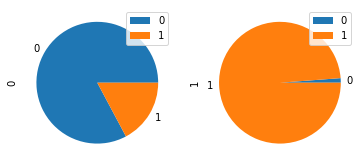

In [37]:
ct = pd.crosstab(actual, pred)

pl = ct.plot(kind="pie",subplots=True, stacked=False, rot=1)